In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [14]:
# Shared Generator Layers
class SharedGeneratorLayers(nn.Module):
    def __init__(self):
        super(SharedGeneratorLayers, self).__init__()
        self.main = nn.Sequential(
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [15]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, shared_layers):
        super(Generator, self).__init__()
        self.fc = nn.Linear(latent_dim, 256)
        self.shared_layers = shared_layers

    def forward(self, z):
        x = self.fc(z)
        x = self.shared_layers(x)
        return x

In [16]:
# Shared Discriminator and Classifier Layers
class SharedDiscriminatorClassifierLayers(nn.Module):
    def __init__(self):
        super(SharedDiscriminatorClassifierLayers, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [17]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, shared_layers):
        super(Discriminator, self).__init__()
        self.shared_layers = shared_layers
        self.fc = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.shared_layers(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [18]:
# Classifier
class Classifier(nn.Module):
    def __init__(self, shared_layers, num_generators):
        super(Classifier, self).__init__()
        self.shared_layers = shared_layers
        self.fc = nn.Linear(256, num_generators)

    def forward(self, x):
        x = self.shared_layers(x)
        x = self.fc(x)
        return x

In [19]:
import matplotlib.pyplot as plt


def generate_and_plot(generators, latent_dim, device):
    num_generators = len(generators)  # Get the number of generators
    images_per_generator = 5  # Set how many images to display per generator
    fig, axes = plt.subplots(num_generators, images_per_generator, figsize=(images_per_generator * 2, num_generators * 2))
    
    # Loop through each generator and generate samples
    for gen_idx, generator in enumerate(generators):
        generator.eval()  # Set the generator to evaluation mode
        with torch.no_grad():
            # Generate latent vectors for the generator
            z = torch.randn(images_per_generator, latent_dim, device=device)
            generated_images = generator(z).cpu().numpy()  # Generate images and move them to CPU for plotting

        # Visualize the images generated by this generator
        for img_idx in range(images_per_generator):
            ax = axes[gen_idx, img_idx]
            
            # If the generated images are flattened (like MNIST), reshape them
            image = generated_images[img_idx]
            
            if image.shape == (784,):  # For MNIST, where images are flattened
                image = image.reshape(28, 28)  # Reshape to 28x28 for grayscale images
            
            # If working with RGB, ensure image has the shape (height, width, channels)
            elif len(image.shape) == 1 and image.size == 784 * 3:  # Example for flattened RGB
                image = image.reshape(28, 28, 3)  # Reshape to (28, 28, 3) for RGB
            
            ax.imshow(image, cmap='gray' if image.ndim == 2 else None)  # Use 'gray' cmap for grayscale
            ax.set_title(f"Generator {gen_idx + 1}")  # Label the image with the generator index
            ax.axis('off')  # Turn off the axis

    plt.tight_layout()
    plt.show()


In [20]:
def train_mgans(generators, discriminator, classifier, train_loader, latent_dim, num_epochs, beta, device, visualize_frequency):
    criterion_bce = nn.BCELoss()
    criterion_ce = nn.CrossEntropyLoss()

    # Collect generator parameters
    gen_params = []
    for gen in generators:
        gen_params += list(gen.fc.parameters())
    gen_params += list(generators[0].shared_layers.parameters())  # Shared layers are the same

    optimizer_G = optim.Adam(gen_params, lr=0.0002, betas=(0.5, 0.999))

    # Discriminator and Classifier params
    dc_params = list(discriminator.shared_layers.parameters()) + \
                list(discriminator.fc.parameters()) + \
                list(classifier.fc.parameters())
    optimizer_DC = optim.Adam(dc_params, lr=0.0002, betas=(0.5, 0.999))

    # History to track losses
    history = {'d_loss': [], 'g_loss': [], 'c_loss': []}

    for epoch in range(num_epochs):
        for batch_idx, (real_images, _) in enumerate(train_loader):
            # Prepare real images
            real_images = real_images.view(-1, 28 * 28).to(device)
            batch_size_real = real_images.size(0)

            # Labels for real images
            real_labels = torch.ones(batch_size_real, 1).to(device)

            # Zero gradients for discriminator and classifier
            optimizer_DC.zero_grad()

            # Discriminator loss on real images
            outputs = discriminator(real_images)
            d_loss_real = criterion_bce(outputs, real_labels)

            # Prepare fake images and labels
            fake_images_list = []
            fake_labels_list = []
            batch_size_fake = batch_size_real  # For each generator

            for idx, gen in enumerate(generators):
                z = torch.randn(batch_size_fake, latent_dim).to(device)
                fake_images = gen(z)
                fake_images_list.append(fake_images)
                fake_labels_list.append(torch.full((batch_size_fake,), idx, dtype=torch.long))

            # Concatenate fake images and labels
            fake_images = torch.cat(fake_images_list, dim=0)
            fake_labels = torch.cat(fake_labels_list, dim=0).to(device)

            # Labels for fake images for discriminator
            fake_labels_dis = torch.zeros(fake_images.size(0), 1).to(device)

            # Discriminator loss on fake images
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion_bce(outputs, fake_labels_dis)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_DC.step()

            # Train Classifier
            optimizer_DC.zero_grad()
            outputs = classifier(fake_images.detach())
            c_loss = beta * criterion_ce(outputs, fake_labels)
            c_loss.backward()
            optimizer_DC.step()

            # Train Generators
            optimizer_G.zero_grad()

            # Generator adversarial loss
            outputs = discriminator(fake_images)
            real_labels_gen = torch.ones(fake_images.size(0), 1).to(device)
            g_loss_adv = criterion_bce(outputs, real_labels_gen)

            # Generator classification loss
            outputs = classifier(fake_images)
            g_loss_cls = criterion_ce(outputs, fake_labels)

            # Total generator loss
            g_loss = g_loss_adv - beta * g_loss_cls
            g_loss.backward()
            optimizer_G.step()

            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'D Loss: {d_loss.item():.4f}, C Loss: {c_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

            # Save losses
            history['d_loss'].append(d_loss.item())
            history['g_loss'].append(g_loss.item())
            history['c_loss'].append(c_loss.item())

        # Visualize every 3 epochs
        if (epoch + 1) % visualize_frequency == 0:
            print(f'Generating samples at epoch {epoch + 1}')
            generate_and_plot(generators, latent_dim, device)

    return history

In [21]:
# Hyperparameters
batch_size = 64
num_epochs = 3
learning_rate = 0.0002
latent_dim = 100
num_generators = 5
beta = 1.0  # Diversity hyperparameter
visualize_frequency = 1

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [22]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size * num_generators, shuffle=True)


In [23]:
def plot_training_history(history, num_epochs):
    # Extract losses from history
    d_loss = history['d_loss']  # Discriminator loss
    g_loss = history['g_loss']  # Generator loss
    c_loss = history['c_loss']  # Classifier loss

    # Plot Discriminator Loss
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss, label='Discriminator Loss', color='blue')
    
    # Plot Generator Loss
    plt.plot(g_loss, label='Generator Loss', color='green')

    # Plot Classifier Loss
    plt.plot(c_loss, label='Classifier Loss', color='red')

    # Labels and Title
    plt.title(f'Loss Curves over {num_epochs} Epochs')
    plt.xlabel('Batch Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

Epoch [1/3], Batch [0/188], D Loss: 1.3920, C Loss: 1.6111, G Loss: -0.8949
Epoch [1/3], Batch [100/188], D Loss: 1.1489, C Loss: 1.6105, G Loss: -0.4925
Generating samples at epoch 1


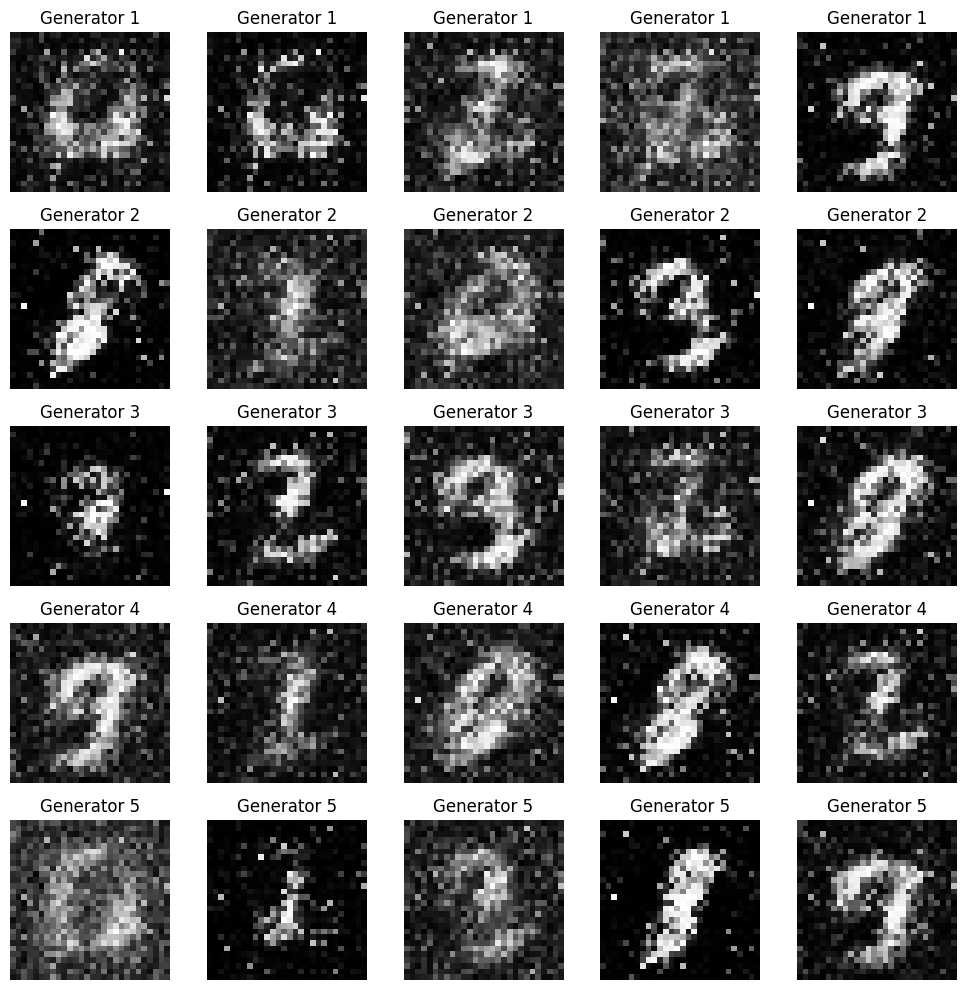

Epoch [2/3], Batch [0/188], D Loss: 1.1119, C Loss: 1.6100, G Loss: -0.6507
Epoch [2/3], Batch [100/188], D Loss: 0.9514, C Loss: 1.6095, G Loss: -0.1920
Generating samples at epoch 2


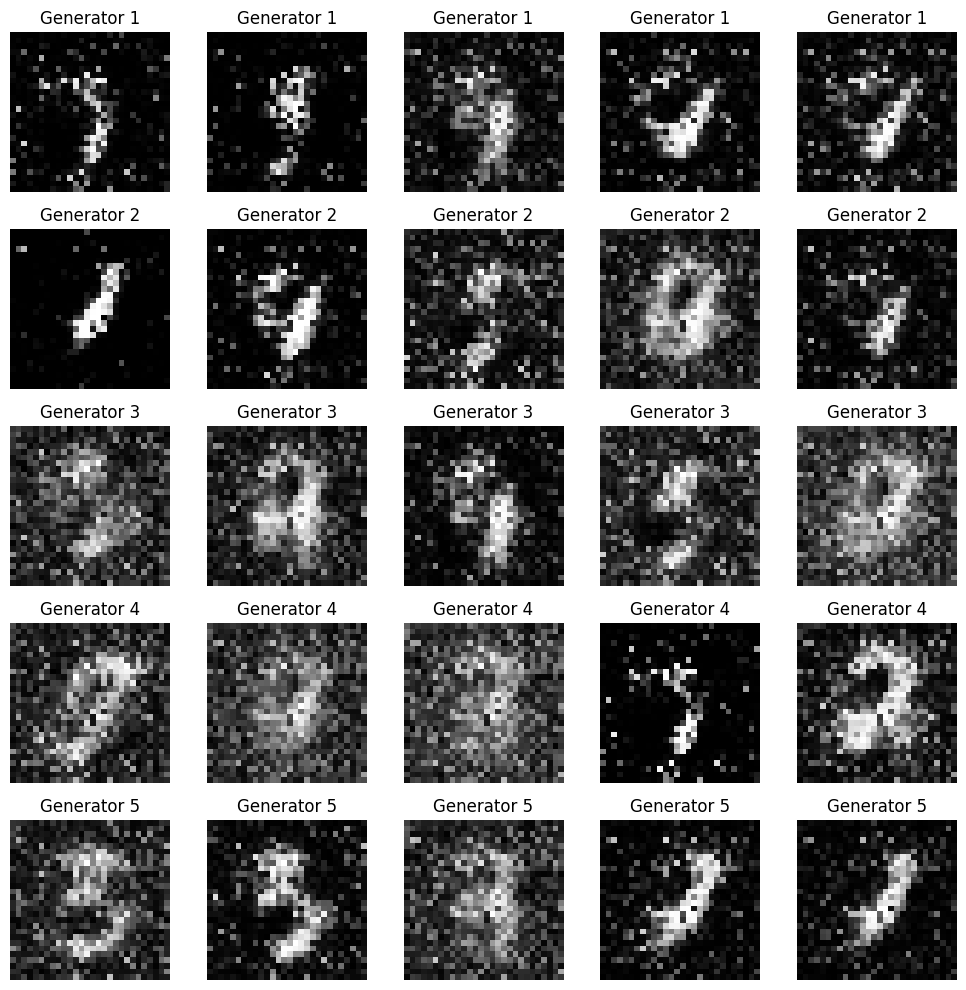

Epoch [3/3], Batch [0/188], D Loss: 0.9288, C Loss: 1.6119, G Loss: -0.2659
Epoch [3/3], Batch [100/188], D Loss: 0.8846, C Loss: 1.6101, G Loss: -0.2674
Generating samples at epoch 3


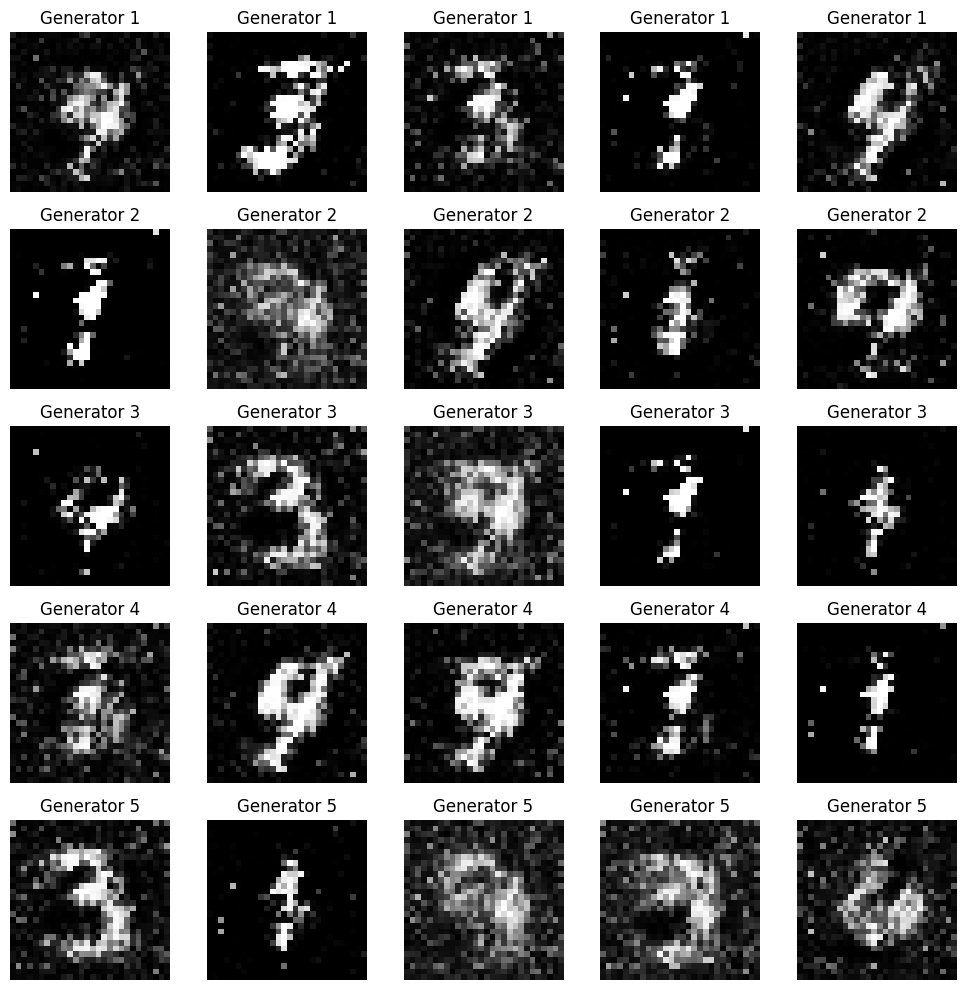

In [24]:


# Initialize models
shared_generator_layers = SharedGeneratorLayers().to(device)
shared_disc_class_layers = SharedDiscriminatorClassifierLayers().to(device)

generators = [Generator(latent_dim, shared_generator_layers).to(device) for _ in range(num_generators)]
discriminator = Discriminator(shared_disc_class_layers).to(device)
classifier = Classifier(shared_disc_class_layers, num_generators).to(device)

# Train the model
history = train_mgans(generators, discriminator, classifier, train_loader, latent_dim, num_epochs, beta, device, visualize_frequency)


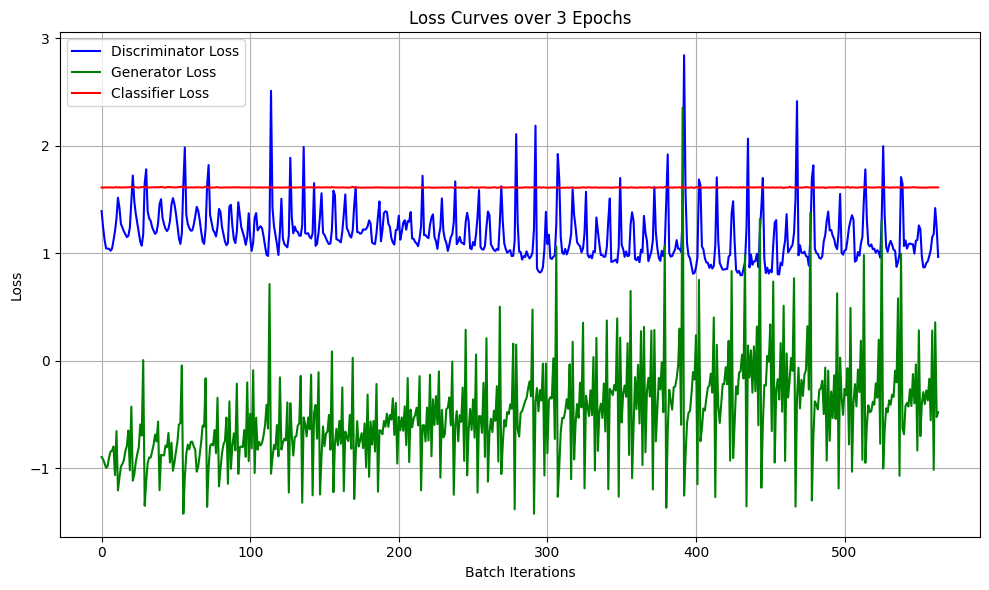

In [25]:
plot_training_history(history, num_epochs)